In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras.layers import Dropout

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
class_names = ["attB", "attP"]

The code in the following cell for the following functions was adapted from our RNN implementation: load_data(...), pad_zeros(...), get_y(...).

In [3]:
char2index = {'A':[1, 0, 0, 0], 'C':[0, 1, 0, 0], 'G':[0, 0, 1, 0], 'T':[0, 0, 0, 1]}

def load_data(path):
  df = pd.read_csv(path, sep='\t')
  X = [[char2index[char] for char in seq] for seq in df.attb]
  Y = [[char2index[char] for char in seq] for seq in df.attp]
  return X, Y

train_attb, train_attp = load_data('set1/attB2attP/train.tsv')
dev_attb, dev_attp = load_data('set1/attB2attP/dev.tsv')
test_attb, test_attp = load_data('set1/attB2attP/test.tsv')

def pad_zeros(data, max_pad=160):
  padded_data = []
  for row in data:
    if max_pad - len(row) > 0:
        row = row + [[0, 0, 0, 0]]*(max_pad - len(row))
    padded_data.append(row)
  return np.array(padded_data)


def get_y(attb, attp):
    y_to_return = np.array(len(attb) * [0] + len(attp) * [1])
    return y_to_return.reshape(y_to_return.shape[0], 1)

print(len(train_attb))
print(len(train_attp))
print(len(train_attb + train_attp))
train_x = train_attb + train_attp
dev_x = dev_attb + dev_attp
test_x = test_attb + test_attp


train_x, train_y = pad_zeros(train_x), get_y(train_attb, train_attp)
dev_x, dev_y = pad_zeros(dev_x), get_y(dev_attb, dev_attp)
test_x, test_y = pad_zeros(test_x), get_y(test_attb, test_attp)

train_x = pad_zeros(train_x)
dev_x = pad_zeros(dev_x)
test_x = pad_zeros(test_x)

print(train_y.shape)
print(train_x.shape)
print(train_x.shape)
print(test_x.shape)

20301
20301
40602
(40602, 1)
(40602, 160, 4)
(40602, 160, 4)
(11404, 160, 4)


The code for this model was adapted from the following source: https://www.tensorflow.org/tutorials/keras/classification

In [4]:
def get_model(l1_val=None, middle_layer_val=128, middle_layer_activation="relu"):
    model_to_return = keras.Sequential([
        keras.layers.Flatten(input_shape=(160, 4))
    ])
    if l1_val is not None:
        model_to_return.add(keras.layers.Dense(middle_layer_val, input_dim=160,
                                               activation=middle_layer_activation,
                                               activity_regularizer=regularizers.l1(l1_val)))
    else:
        model_to_return.add(keras.layers.Dense(middle_layer_val, activation=middle_layer_activation))

    model_to_return.add(keras.layers.Dense(2, activation='softmax'))
    return model_to_return

def fit_model(model, train_x_arr, train_y_arr, verbose=2, epochs=10):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(train_x_arr, train_y_arr, epochs=epochs, shuffle=True, verbose=verbose)

def eval_model(model, test_x_arr, test_y_arr):
    return model.evaluate(test_x_arr,  test_y_arr, verbose=0)

In [5]:
model = get_model()
fit_model(model, train_x, train_y)
dev_loss, dev_acc = eval_model(model, dev_x, dev_y)
print('Development  set accuracy:', dev_acc)
test_loss, test_acc = eval_model(model, test_x, test_y)
print('Test  set accuracy:', test_acc)

Train on 40602 samples
Epoch 1/10
40602/40602 - 3s - loss: 0.4974 - accuracy: 0.7521
Epoch 2/10
40602/40602 - 2s - loss: 0.3291 - accuracy: 0.8544
Epoch 3/10
40602/40602 - 2s - loss: 0.2268 - accuracy: 0.9049
Epoch 4/10
40602/40602 - 2s - loss: 0.1508 - accuracy: 0.9434
Epoch 5/10
40602/40602 - 2s - loss: 0.0968 - accuracy: 0.9680
Epoch 6/10
40602/40602 - 2s - loss: 0.0635 - accuracy: 0.9814
Epoch 7/10
40602/40602 - 2s - loss: 0.0456 - accuracy: 0.9879
Epoch 8/10
40602/40602 - 2s - loss: 0.0371 - accuracy: 0.9904
Epoch 9/10
40602/40602 - 2s - loss: 0.0330 - accuracy: 0.9913
Epoch 10/10
40602/40602 - 2s - loss: 0.0295 - accuracy: 0.9918
Test accuracy: 0.8506664


In [6]:
predictions = model.predict(test_x)

The code for plotting the image of our one-hot encoded sequence was adapted from the following source: https://www.tensorflow.org/tutorials/keras/classification

[0]


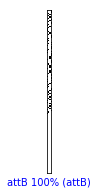

(11404, 2)


In [7]:
def plot_image(i, predictions_array, true_label, img):
    """
    Plots a sample image from our dataset.
    """
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    print(true_label)
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label[0]]),
                                color=color)

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_y, test_x)
plt.show()
print(predictions.shape)

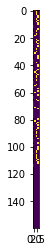

In [8]:
plt.figure()
plt.imshow(train_x[0])
plt.grid(False)
plt.show()

The code for plotting the image of our one-hot encoded sequence was adapted from the following source: https://www.tensorflow.org/tutorials/keras/classification

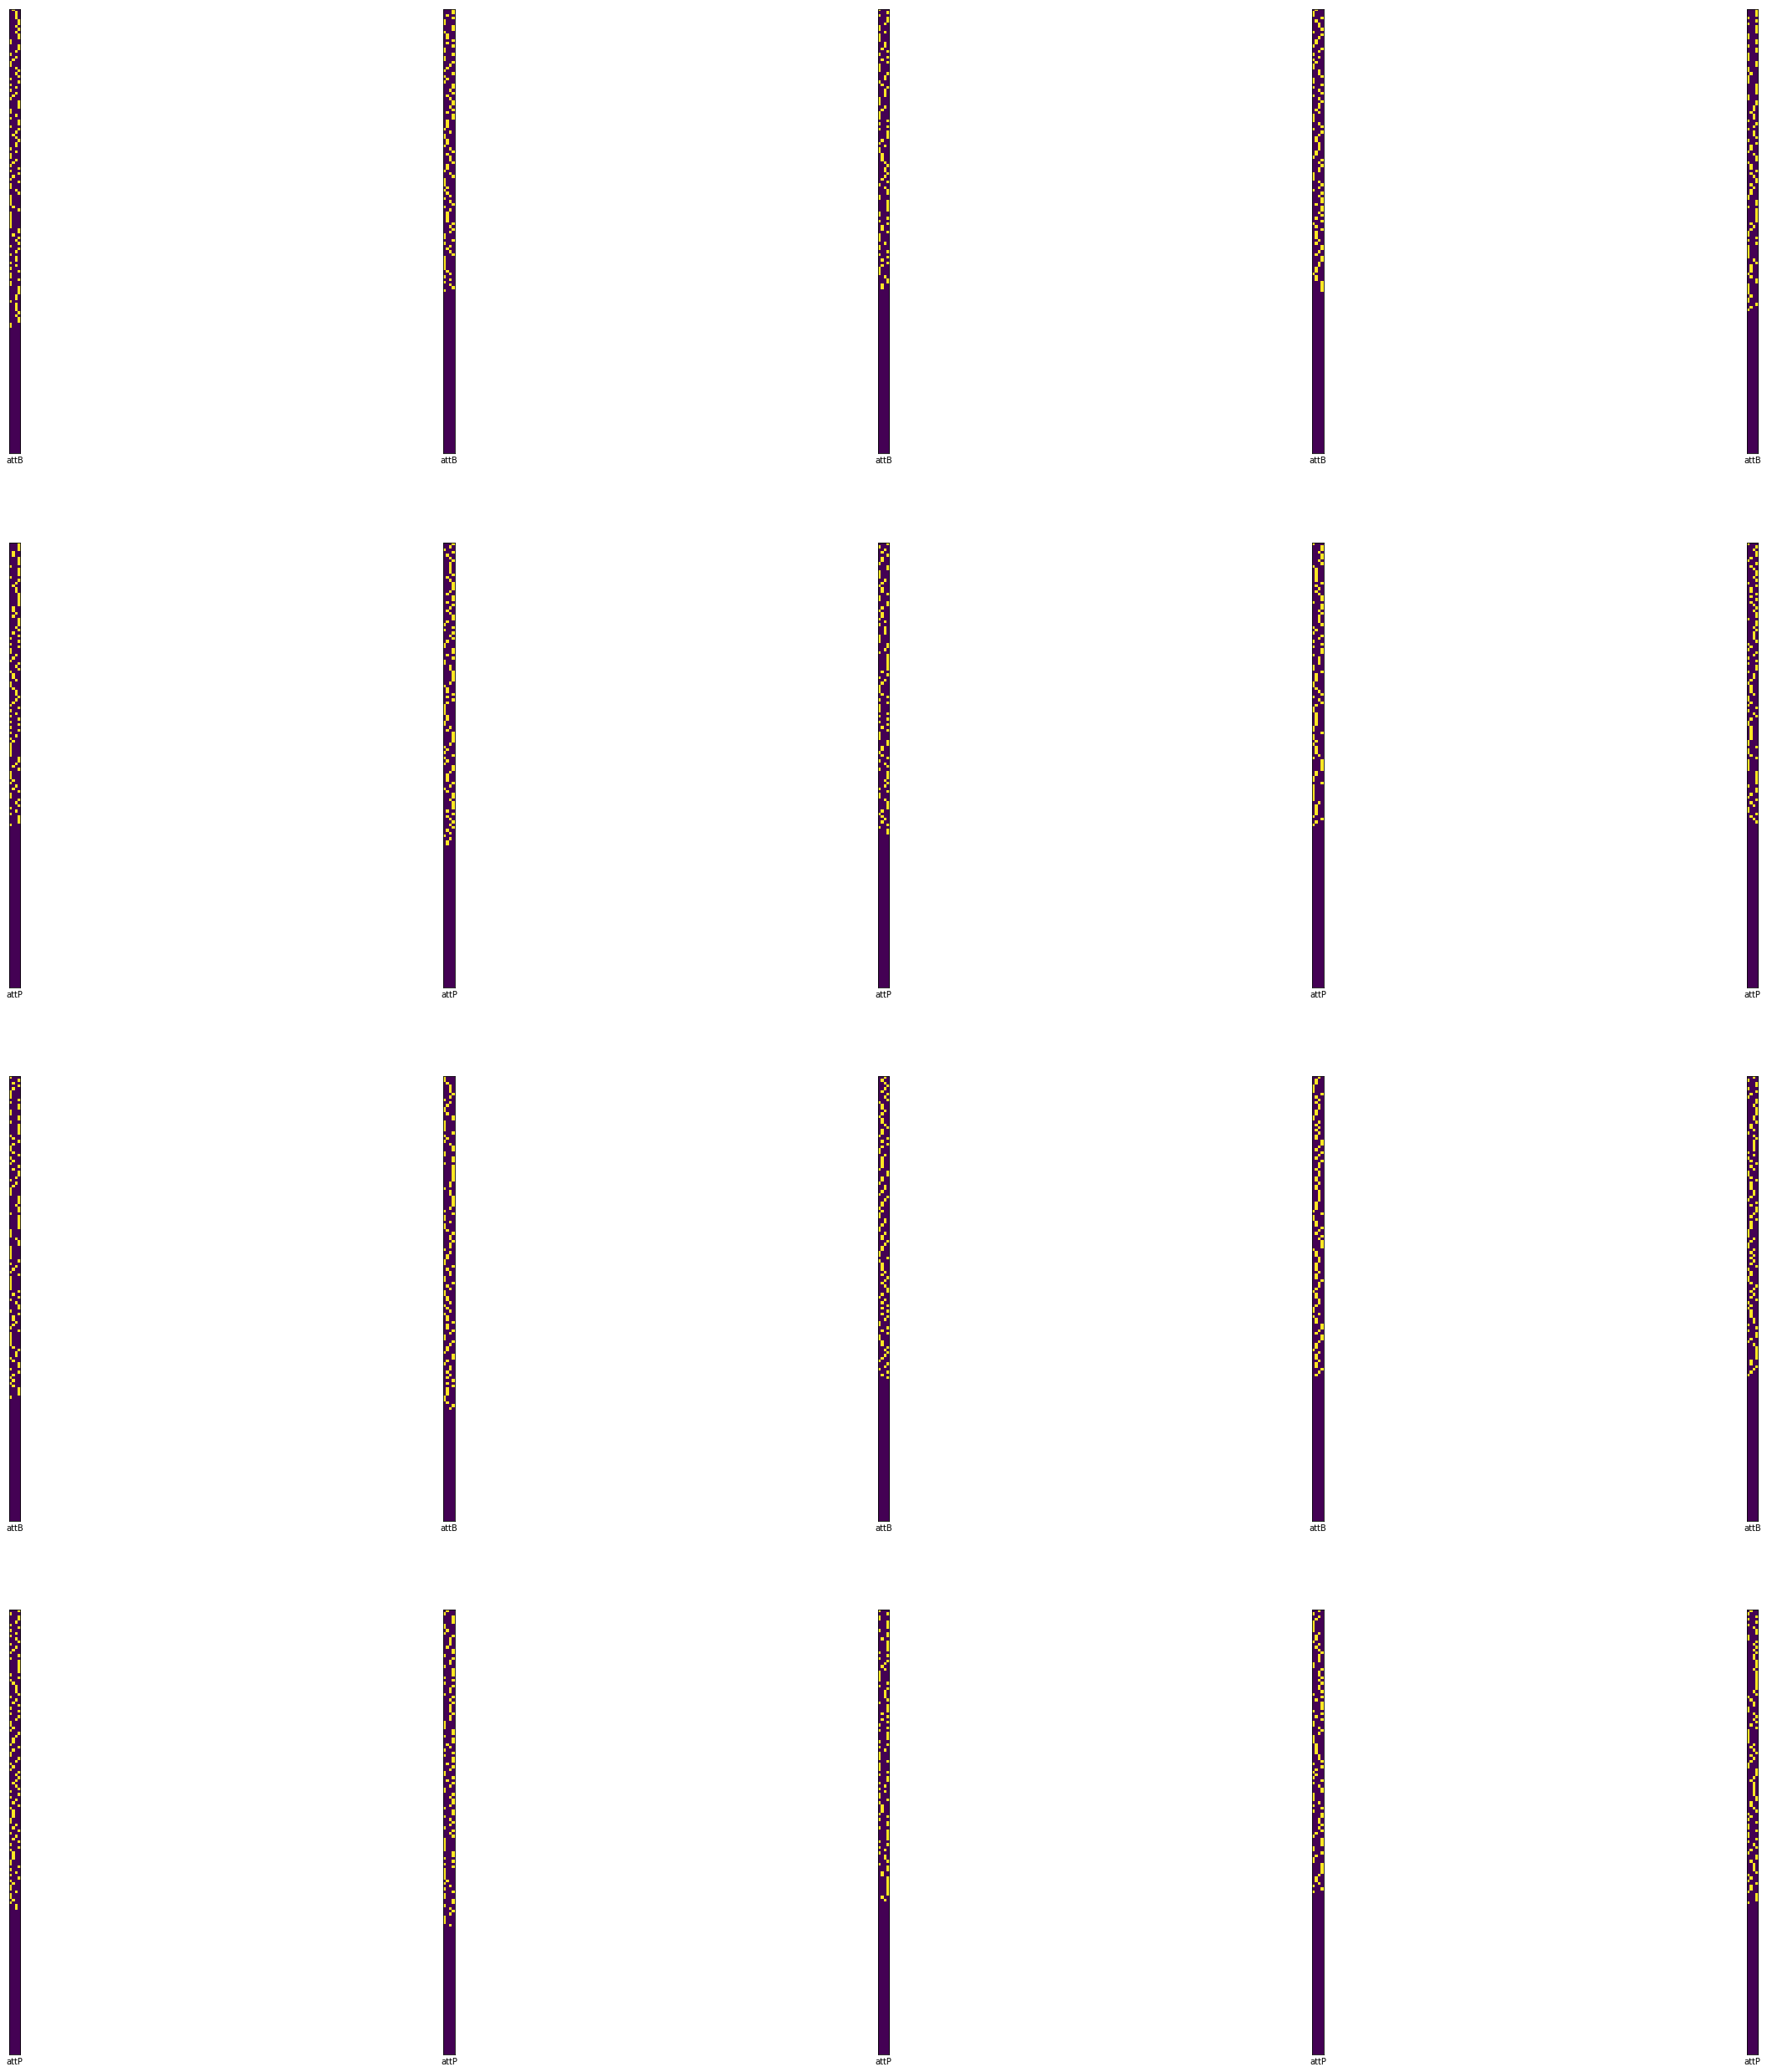

In [9]:
plt.figure(figsize=(45,45))
range_to_show = 20
for i in range(range_to_show):
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    item_to_get = len(train_x) - i if int(i / 5) % 2 == 1 else i
    plt.imshow(train_x[item_to_get])
    plt.xlabel(class_names[train_y[item_to_get][0]])
plt.show()

## Regularization and Data Augmentation

We now have a training accuracy of 99.3% and a test accuracy of 85.6%. We see that we have high variance and perhaps are overfitting our training set.

In [10]:
def get_hyperparameters(simple=False):
    """
    :param simple: Whether or not to return only two hyperparameter configurations. For debugging.
    :return: Several hyperparamter configurations consisting of varying combinations of activation functions, hidden unit amounts, and l1 regularization constants.
    """
    activations = ["relu", "sigmoid"]
    layer_vals = [8, 32, 64, 128]
    l1_vals = np.random.exponential(scale=0.015, size=(5,)).reshape(5, 1)
    hyperparameters_to_return = []
    print(l1_vals)
    if simple:
        return [{
                    'activation': activations[0], 
                    'layer_val': 128,
                    'l1': 0.05
                },
                {
                    'activation': activations[1], 
                    'layer_val': 128,
                    'l1': 0.05
                }]

    for act in activations:
        for layer_val in layer_vals:
            for l_val in l1_vals:
                hyperparameters_to_return.append({
                    'activation': act, 
                    'layer_val': layer_val,
                    'l1': l_val
                })
    return hyperparameters_to_return

In [ ]:
dev_accuracies = []
hyperparameters = get_hyperparameters(simple=False)
print(hyperparameters)
print("We are testing " + str(len(hyperparameters)) + ".")
for param in hyperparameters:
    print(param)
for hyper_params in hyperparameters:
    model_extended = get_model(l1_val=hyper_params['l1'],
                               middle_layer_val=hyper_params['layer_val'], 
                               middle_layer_activation=hyper_params['activation'])
    fit_model(model_extended, 
              train_x, 
              train_y,
              verbose=0)
    dev_loss, dev_acc = eval_model(model_extended, dev_x, dev_y)
    dev_accuracies.append(dev_acc)
    print(dev_accuracies)
    print(hyper_params)
    print('Development set accuracy:', dev_acc)

dev_accuracies = np.array(dev_accuracies)
print(dev_accuracies)
print(max(dev_accuracies))
index_of_hyper_to_get = dev_accuracies.argmax(axis=0)
print(hyperparameters[index_of_hyper_to_get])

None of these configurations resulted in an improved development set accuracy.

## CNN

The code for the CNN was adapted from the following source: https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

In [12]:
def create_model(input_shape):
    
    model_to_return = Sequential()
    convo_add = Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(input_shape[1], input_shape[2], 1))
    model_to_return.add(convo_add)
    model_to_return.add(Conv2D(32, kernel_size=3, padding='same',activation='relu'))
    model_to_return.add(MaxPooling2D(pool_size=(2, 2)))
    
    model_to_return.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model_to_return.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model_to_return.add(MaxPooling2D(pool_size=(2, 2)))
    model_to_return.add(Dropout(0.25))
    
    model_to_return.add(Flatten())
    model_to_return.add(Dense(512, activation='relu'))
    model_to_return.add(Dropout(0.5))
    model_to_return.add(Dense(2, activation='softmax'))
    return model_to_return

In [15]:
train_x_cnn, train_y_cnn = np.array(train_x), np.array(train_y)
print(train_x_cnn.shape)
print(train_y_cnn.shape)
train_x_cnn = train_x_cnn.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
model = create_model(train_x_cnn.shape)
fit_model(model, train_x_cnn, train_y_cnn)

(40602, 160, 4)
(40602, 1)
Epoch 1/10
 - 138s - loss: 0.5374 - accuracy: 0.7242
Epoch 2/10
 - 129s - loss: 0.4288 - accuracy: 0.7968
Epoch 3/10
 - 132s - loss: 0.3619 - accuracy: 0.8322
Epoch 4/10
 - 137s - loss: 0.3110 - accuracy: 0.8612
Epoch 5/10
 - 137s - loss: 0.2725 - accuracy: 0.8799
Epoch 6/10
 - 133s - loss: 0.2403 - accuracy: 0.8950
Epoch 7/10
 - 129s - loss: 0.2156 - accuracy: 0.9079
Epoch 8/10
 - 133s - loss: 0.1917 - accuracy: 0.9200
Epoch 9/10
 - 128s - loss: 0.1751 - accuracy: 0.9274
Epoch 10/10
 - 131s - loss: 0.1567 - accuracy: 0.9349


In [16]:
dev_x_cnn = dev_x.reshape(dev_x.shape[0], dev_x.shape[1], dev_x.shape[2], 1)
dev_loss, dev_acc = eval_model(model, dev_x_cnn, dev_y)
print('Development set accuracy:', dev_acc)

Dev accuracy: 0.8725823163986206


The visualization for the classes was adapted from the following source: https://jacobgil.github.io/deeplearning/class-activation-maps

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 160, 4, 64)        640       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 160, 4, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 80, 2, 32)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 80, 2, 64)         18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 80, 2, 64)         36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 1, 64)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 1, 64)        

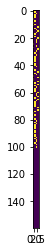

(1, 160, 4, 64)


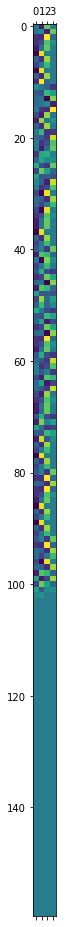

In [37]:
def visualize_class_activation_map():
    original_img = dev_x_cnn[0]
    width, height, _ = original_img.shape # original_img.shape
    
    img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
    
    class_weights = model.layers[-1].get_weights()[0]
    
    get_output = K.function([model.layers[0].input], \
                [model.layers[len(model.layers) - 1].output, 
    model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    conv_outputs = conv_outputs[0, :, :, :]

    # Class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
    target_class = 1
    for i, w in enumerate(class_weights[:, target_class]):
            cam += w * conv_outputs[i, :, :]

model.summary()

layer_outputs = [layer.output for layer in model.layers[:12]]

from keras import models
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

img_tensor = np.expand_dims(dev_x_cnn[10], axis=0)
img_tensor = img_tensor / 255
img_tensor_to_show = img_tensor[0,:,:,0:1].reshape(160,4)
print(img_tensor_to_show.shape)
plt.imshow(img_tensor_to_show)
plt.show()

activations = activation_model.predict(img_tensor) 
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 32], cmap='viridis')

DEBUG = False

if DEBUG:
    last_layer_act = activations[3]
    print(last_layer_act.shape)
    plt.matshow(last_layer_act[:, :], cmap='viridis')
    
    last_layer_act = activations[1]
    print(last_layer_act.shape)
    plt.matshow(last_layer_act[0, :, :, 1], cmap='viridis')

    last_layer_act = activations[len(activations) - 2]
    print(last_layer_act.shape)
    plt.matshow(last_layer_act[:], cmap='viridis')


    last_layer_act = activations[len(activations) - 1]
    print(last_layer_act.shape)
    plt.matshow(last_layer_act[:], cmap='viridis')


In [ ]:
model = create_model(train_x_cnn.shape)
fit_model(model, train_x_cnn, train_y_cnn, epochs=100)

In [ ]:
dev_x_cnn = dev_x.reshape(dev_x.shape[0], dev_x.shape[1], dev_x.shape[2], 1)
dev_loss, dev_acc = eval_model(model, dev_x_cnn, dev_y)
print('Development set accuracy:', dev_acc)